### GP求解旅行商问题

GP当然也可以用于求解组合优化问题。在这里，我们将使用GP来解决旅行商问题（TSP）。TSP是指一个旅行商要拜访n个城市，他必须从自己所在的城市出发，到这n个城市中的每一个城市去一次，最后回到自己所在的城市，而且每个城市只能去一次，求解从出发到回到自己所在城市的最短路径。

旅行商问题是一个NP难问题，通常可以使用遗传算法求解。但是遗传算法的缺点是需要大量的迭代次数才能收敛到最优解。因此我们将使用启发式函数来求解这个问题。启发式函数是一个根据特征输入返回排序分数的函数。排序分数将用于选择下一个城市。

在本教程中，我们将使用距离作为启发式函数的输入，也就是说，我们的启发式函数是距离的非线性变换函数。我们将尝试使用GP来演化这个函数。

### 评估函数
对于组合优化问题，评估函数相对复杂，需要根据领域知识进行设计。

In [1]:
import numpy as np
from deap import algorithms, base, creator, tools, gp

def select_next_city(current_city, unvisited_cities, heuristic, distance_matrix):
    scores = []
    for next_city in unvisited_cities:
        # 计算从当前城市到下一个可能城市的距离
        distance = distance_matrix[current_city][next_city]
        # 使用距离作为启发式函数的输入，计算得分
        heuristic_score = heuristic(distance)
        # 计算得分用于选择下一个城市
        # 这里可以直接使用heuristic_score，也可以与距离结合
        # 例如，使用距离的倒数与启发式得分的和
        score = 1 / distance + heuristic_score
        scores.append((next_city, score))

    # 选择得分最高的城市作为下一站
    selected_city = max(scores, key=lambda c: c[1])[0]
    return selected_city

def decode(individual, distance_matrix):
    # 初始化城市列表和路线
    unvisited_cities = list(range(len(distance_matrix)))  # 未访问的城市列表
    route = [unvisited_cities.pop(0)]  # 从第一个城市开始

    # 编译 GP 树为函数
    heuristic = gp.compile(expr=individual, pset=pset)

    # 循环直到所有城市都被访问
    while unvisited_cities:
        # 根据启发式函数和距离选择下一个城市
        current_city = route[-1]  # 获取路线中的最后一个城市作为当前城市
        next_city = select_next_city(current_city, unvisited_cities, heuristic, distance_matrix)
        # 将下一个城市添加到路线中，并将其从未访问城市列表中移除
        route.append(next_city)
        unvisited_cities.remove(next_city)

    # 路径闭环，返回起始城市
    route.append(route[0])
    return route

# 每个城市的坐标在一个单位正方形内随机生成
coordinates = np.random.rand(10, 2)  # 生成10个城市的x,y坐标

# 计算距离矩阵
def calculate_distance_matrix(coords):
    num_cities = len(coords)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                # 计算欧几里得距离
                distance_matrix[i][j] = np.sqrt(np.sum((coords[i] - coords[j])**2))
            else:
                # 城市不与自己连接
                distance_matrix[i][j] = np.inf
    return distance_matrix

distance_matrix = calculate_distance_matrix(coordinates)

# 评价函数，计算路径的总距离
def evalTSP(individual):
    path = decode(individual, distance_matrix)
    distance = sum(distance_matrix[path[i]][path[i-1]] for i in range(1,len(path)))
    return distance,


### 遗传编程算子
一旦问题定义好了，遗传编程算子的定义就变得相对简单。我们可以使用DEAP中内置的算子。

In [2]:
# 初始化GP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 最小化问题
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# 基本函数
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genGrow, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalTSP)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=2)

接下来，我们将使用DEAP内置的演化流程来运行已定义的函数。

In [3]:
# 统计函数
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

population = toolbox.population(n=100)
hof = tools.HallOfFame(1)

# 运行遗传编程算法
algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, mstats, halloffame=hof)

# 输出最好的个体
best_ind = hof[0]
print('Best individual:', best_ind, best_ind.fitness)

   	      	                    fitness                     	                     size                     
   	      	------------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std     	avg 	gen	max	min	nevals	std   
0  	100   	3.19162	0  	3.5749	3.15372	100   	0.120534	5.86	0  	14 	2  	100   	3.5497
1  	89    	3.17056	1  	3.5749	3.15372	89    	0.0825342	6.54	1  	15 	2  	89    	3.34192
2  	94    	3.15793	2  	3.5749	3.15372	94    	0.0419069	6.81	2  	17 	2  	94    	3.52901
3  	93    	3.18741	3  	3.5749	3.15372	93    	0.114263 	7.25	3  	17 	2  	93    	4.1143 
4  	94    	3.17477	4  	3.5749	3.15372	94    	0.0917942	7.33	4  	17 	2  	94    	4.13051
5  	89    	3.17056	5  	3.5749	3.15372	89    	0.0825342	8.08	5  	22 	2  	89    	4.58406
6  	86    	3.17477	6  	3.5749	3.15372	86    	0.0917942	8.34	6  	22 	2  	86    	4.62649
7  	86    	3.17056	7  	3.5749	3.15372	86    	0.0825342	7.77	7  	23 	2  	86    	4.48521
8  	92 

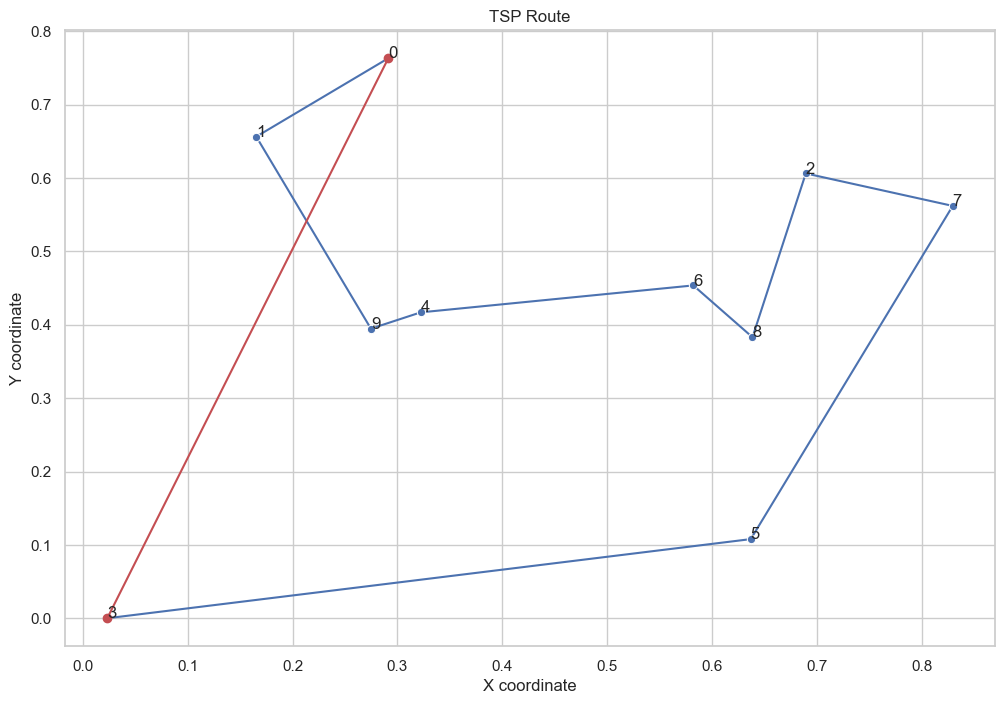

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='notebook', style='whitegrid')

# 绘图展示最佳路径
def plot_route(route, coords):
    plt.figure(figsize=(12, 8))
    
    # 绘制路线
    ax = sns.lineplot(x=coords[route, 0], y=coords[route, 1], marker='o', sort=False)
    
    # 用不同颜色突出显示回到起点的路径
    ax.plot([coords[route[-2]][0], coords[route[0]][0]],
            [coords[route[-2]][1], coords[route[0]][1]], 'r-o')
    
    # 添加城市编号标签
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, f'{i}')
    
    plt.title('TSP Route')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

best_route = decode(best_ind, distance_matrix)
plot_route(best_route, coordinates)